# Лабораторная работа "Задача Коши"

В этой лабораторной работе мы реализуем численное решение задачи Коши.

Вспомогательный код для вычисления и рисования графиков:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math as m
import threading as thr
from ipywidgets import interact, widgets, interactive

class GridFunction:
    def __init__(self, a, b, h, dim=1):
        self.dim = dim
        self.n = int((b - a) / h)
        self.n += (self.n % 2 == 0)

        self.a = a
        self.b = a + h * (self.n - 1)
        self.h = h

        self.x = np.zeros(self.n)
        for i in range(self.n):
            self.x[i] = a + self.h * i

        if self.dim == 0:
            self.y = [[0]] * self.n
        elif self.dim == 1:
            self.y = np.zeros(self.n)
        else:
            np_list = []
            for i in range(self.n):
                np_list.append(np.zeros(self.dim))
            self.y = np.asarray(np_list)

    def calc(self, func, thread=False):
        self.f = func

        if thread:
            def thread_calc(i):
                self.y[i] = func(self.x[i])

            threads = [
                thr.Thread(target=thread_calc, args=(i,))
                for i in range(self.x.size)
            ]
            for thread in threads:
                thread.start()
            for thread in threads:
                thread.join()
        else:
            for i in range(self.x.size):
                self.y[i] = func(self.x[i])

    def plot(self, axes='01', marker='', label='', title_str='', figsize=(9, 6), new=True, ext_plt='', external=False):
        if new and not external:
            fig, self.ax = plt.subplots(figsize=figsize)
            self.ax.set(xlabel='x', ylabel='y', title=title_str)
            self.ax.grid()

        if external:
            self.ax = ext_plt

        if self.dim == 0:
            x = []
            y = []
            for i in range(self.n):
                for j in range(len(self.y[i])):
                    x.append(self.x[i])
                    y.append(self.y[i][j])

            if label == '':
                self.ax.scatter(x, y, s=0.3)
            else:
                self.ax.scatter(x, y, s=0.3, label=label)
                self.ax.legend()
        else:
            x = self.x
            if axes[0] != '0':
                x = self.y
                if self.dim != 1:
                    x = np.split(self.y, self.dim, axis=1)[int(axes[0]) - 1]

            y = self.x
            if axes[1] != '0':
                y = self.y
                if self.dim != 1:
                    y = np.split(self.y, self.dim, axis=1)[int(axes[1]) - 1]

            if label == '':
                self.ax.plot(x, y, marker)
            else:
                self.ax.plot(x, y, marker, label = label)
                self.ax.legend()

class LogError(GridFunction):
    def __init__(self, begin_h, end_h, step_h, true_x, dx):
        super().__init__(begin_h, end_h, step_h)
        self.dx = dx
        self.true_x = true_x

    def plot(self, title_str = ''):
        super().plot(title_str = title_str)
        self.ax.set(xlabel='ln(h)', ylabel='ln(Err)')
        k, b = np.polyfit(self.x, self.y, 1)

        label_str = '{:.2f}*x + {:.2f}'.format(k, b)
        self.ax.plot(self.x, k * self.x + b, 'r-', linewidth=0.5, label=label_str)
        self.ax.legend()

    def calc(self, a, b, x0, method, logarithm = False, dim = 1):
        for i in range(self.n):
            grid_sol_x = GridFunction(a, b, self.x[i], dim)
            grid_sol_x.y[0] = x0
            method(grid_sol_x, self.dx)

            grid_true_x = GridFunction(a, b, self.x[i], dim)
            grid_true_x.calc(self.true_x)

            self.y[i] = np.amax(np.absolute(grid_sol_x.y[-1] - grid_true_x.y[-1]))

            if logarithm:
                self.x[i] = m.log(self.x[i])
                self.y[i] = m.log(self.y[i])

def explicit_euler(gf, f):
    for i in range(1, gf.n):
        gf.y[i] = gf.y[i - 1] + gf.h * f(gf.y[i - 1], gf.x[i - 1])

def runge_kutta_2(gf, f):
    for i in range(1, gf.n):
        gf.y[i] = gf.y[i - 1] + gf.h * f(gf.y[i - 1] + gf.h / 2 * f(gf.y[i - 1], gf.x[i - 1]), gf.x[i - 1] + gf.h / 2)

def runge_kutta_4(gf, f):
    for i in range(1, gf.n):
        k1 = f(gf.y[i - 1], gf.x[i - 1])
        k2 = f(gf.y[i - 1] + gf.h * k1 / 2, gf.x[i - 1] + gf.h / 2)
        k3 = f(gf.y[i - 1] + gf.h * k2 / 2, gf.x[i - 1] + gf.h / 2)
        k4 = f(gf.y[i - 1] + gf.h * k3, gf.x[i - 1] + gf.h)
        gf.y[i] = gf.y[i - 1] + gf.h / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

## Решение ДУ

В качастве уравнения возьмем $$x(t)' = \frac{1}{tx}$$
на отрезке $[a, b]$. $\\$
Решение $x(t) = \sqrt{2c + 2\ln{t}}$

In [2]:
my_dx  = lambda x, t: 1 / (t * x)
my_x_c = lambda t, c: m.sqrt(2 * c + 2 * m.log(t))

def du1(begin_h, end_h, step_h, x0, t0, method):
    a = t0; b = a + 1

    c = (x0 ** 2) / 2 - m.log(t0)
    my_x = lambda t: my_x_c(t, c)

    logerr = LogError(begin_h, end_h, step_h, my_x, my_dx)
    logerr.calc(a, b, x0, method, True)
    logerr.plot()

#### Явная схема Эйлера

$$x_{n+1} = x_n + \frac{\tau}{t_n x_n}$$

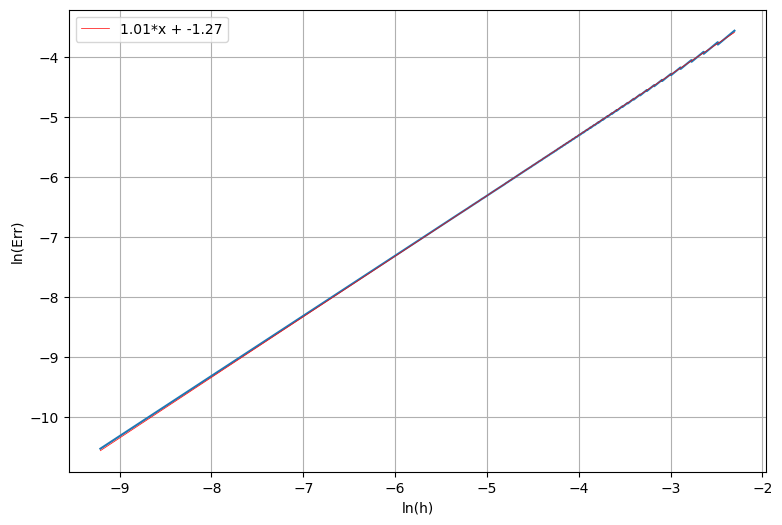

In [3]:
du1(0.0001, 0.1, 0.0001, 1, 1, explicit_euler)

#### Неявная схема Эйлера

$$x_{n+1} = \frac{x_n + \sqrt{x_n^2 + \frac{4 \tau}{t_n}}}{2}$$

In [4]:
def implicit_euler(gf, f):
    for i in range(1, gf.n):
        gf.y[i] = (gf.y[i - 1] + m.sqrt(gf.y[i - 1] ** 2 + 4 * gf.h / gf.x[i])) / 2

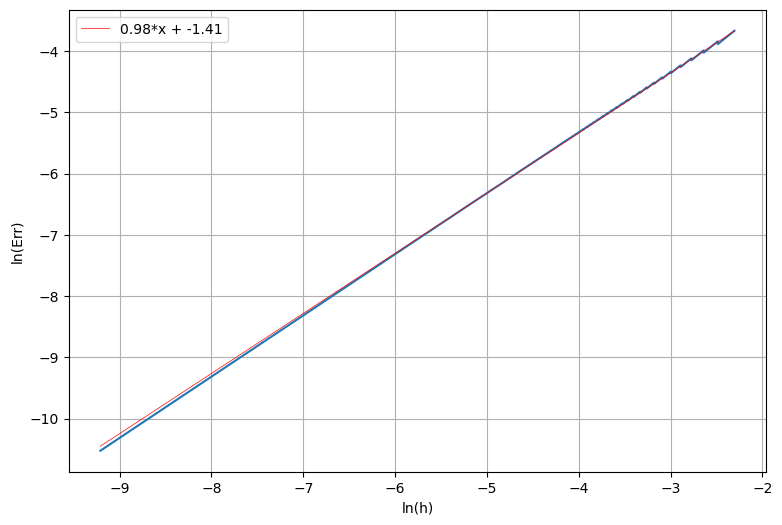

In [5]:
du1(0.0001, 0.1, 0.0001, 1, 1, implicit_euler)

#### Метод трапеций

$$x_{n+1} = \frac{x_n + \frac{\tau}{2 t_n x_n} + \sqrt{\left(x_n + \frac{\tau}{2 t_n x_n}\right)^2 + \frac{2 \tau}{t_n}}}{2}$$

In [6]:
def trapezoidal(gf, f):
    for i in range(1, gf.n):
        gf.y[i] = ((gf.y[i - 1] + gf.h / (2 * gf.x[i - 1] * gf.y[i - 1])) + m.sqrt((gf.y[i - 1] + gf.h / (2 * gf.x[i - 1] * gf.y[i - 1])) ** 2 + 2 * gf.h / gf.x[i])) / 2

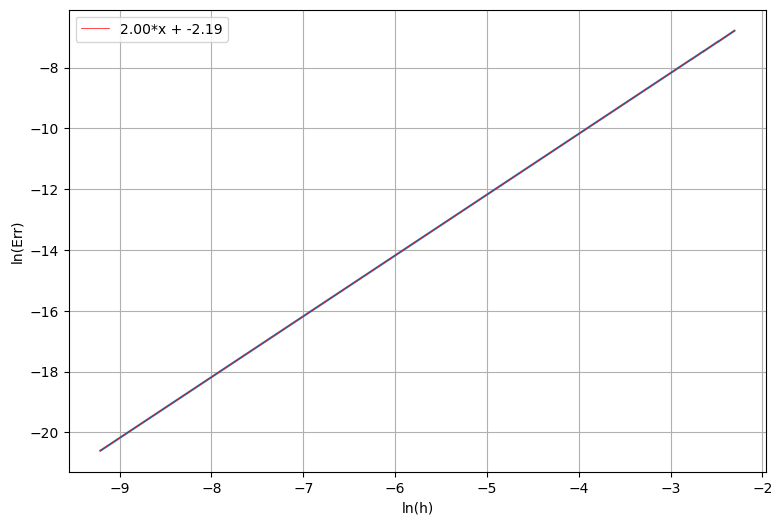

In [7]:
du1(0.0001, 0.1, 0.0001, 1, 1, trapezoidal)

#### Метод Рунге-Кутты 2 порядка

$$x_{n+1} = x_n + \frac{\tau}{\left(x_n + \frac{\tau}{2 x_n t_n}\right)\left(t_n + \frac{\tau}{2}\right)}$$

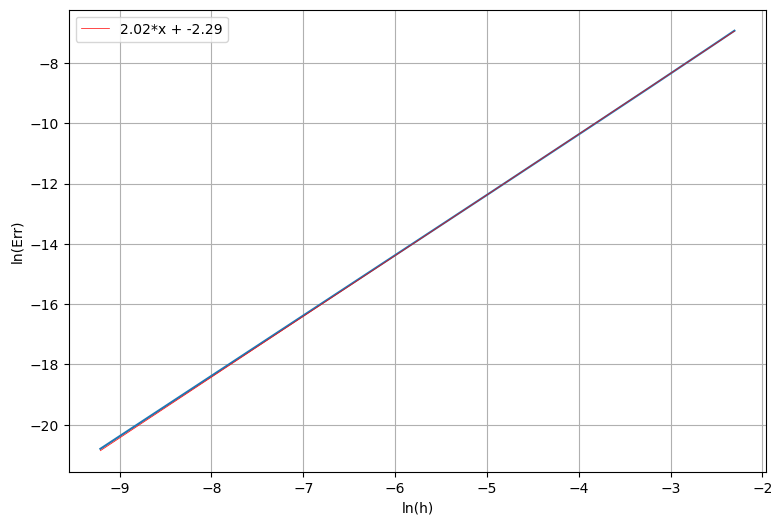

In [8]:
du1(0.0001, 0.1, 0.0001, 1, 1, runge_kutta_2)

#### Метод Рунге-Кутты 4 порядка

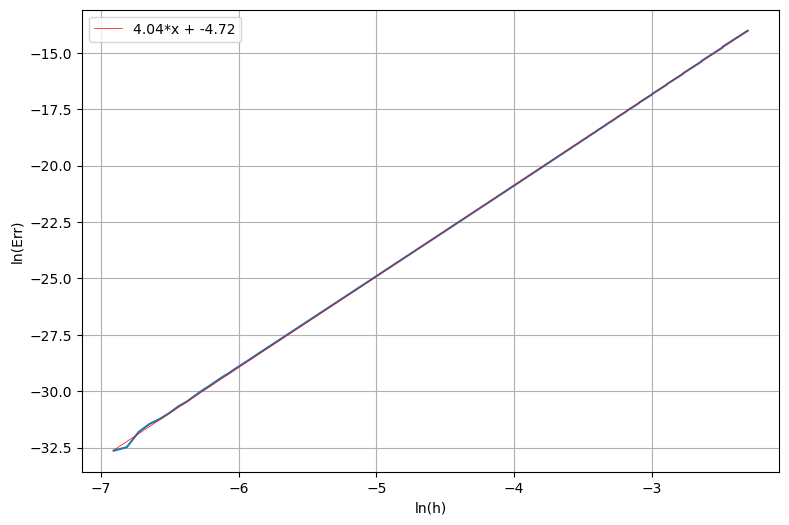

In [9]:
du1(0.001, 0.1, 0.0001, 1, 1, runge_kutta_4)

### Дифференциальное уравнение Бернулли

В качастве уравнения возьмем $$x(t)' = \alpha x(1-x)$$
на отрезке $[a, b]$. $\\$
Решение $x(t) = \frac{e^{\alpha t}}{c + e^{\alpha t}}$

In [10]:
def du2(begin_h, end_h, step_h, a, x0, t0, method):
    my_dx  = lambda x, t: a * x * (1 - x)
    my_x_c = lambda t, c: m.exp(a * t) / (c + m.exp(a * t))

    a = t0; b = a + 10

    c = m.exp(a * t0) * (1 - x0) / x0
    my_x = lambda t: my_x_c(t, c)

    logerr = LogError(begin_h, end_h, step_h, my_x, my_dx)
    logerr.calc(a, b, x0, method, True)
    logerr.plot()

#### Явная схема Эйлера

$$x_{n+1} = x_n + \tau \alpha x_n(1 - x_n)$$

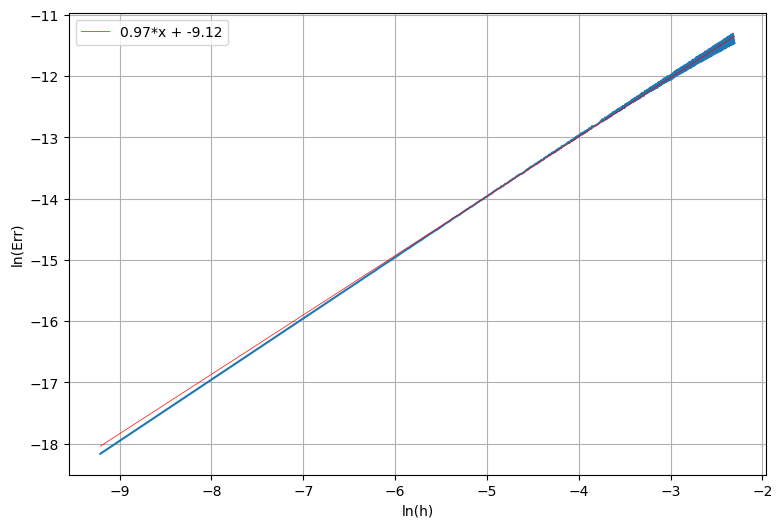

In [11]:
du2(0.0001, 0.1, 0.0001, 1, 2, 1, explicit_euler)

#### Неявная схема Эйлера

$$x_{n+1} = \frac{\tau - 1 + \sqrt{(\tau - 1)^2 + 4 \tau x_n}}{2 \tau}$$

In [12]:
def implicit_euler(gf, f):
    for i in range(1, gf.n):
        gf.y[i] = (gf.h - 1 + m.sqrt((gf.h - 1) ** 2 + 4 * gf.h * gf.y[i - 1])) / (2 * gf.h)

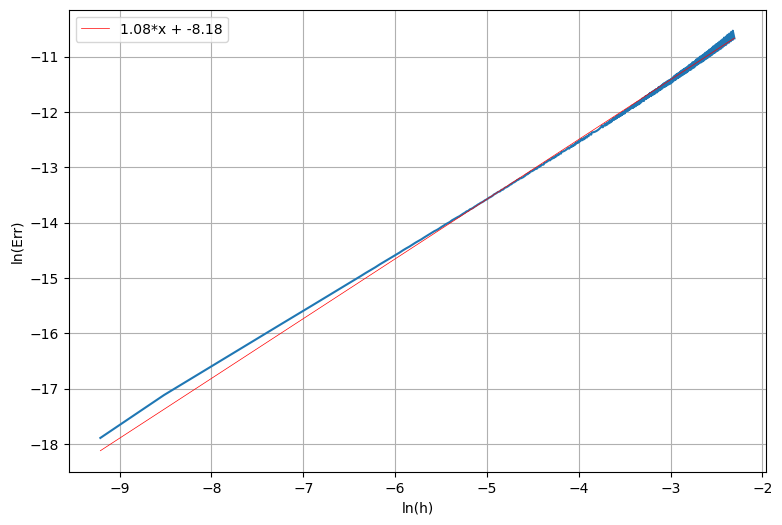

In [13]:
du2(0.0001, 0.1, 0.0001, 1, 3, 1, implicit_euler)

#### Метод трапеций

$$x_{n+1} = \frac{\frac{\tau}{2} - 1 + \sqrt{\left(\frac{\tau}{2} - 1\right)^2 + 2 \tau x_n\left(1 + \frac{\tau}{2}(1 - x_n)\right)}}{\tau}$$

In [14]:
def trapezoidal(gf, f):
    for i in range(1, gf.n):
        gf.y[i] = ((gf.h / 2 - 1) + m.sqrt((gf.h / 2 - 1) ** 2 + 2 * gf.h * gf.y[i - 1] * (1 + gf.h / 2 * (1 - gf.y[i - 1])))) / gf.h

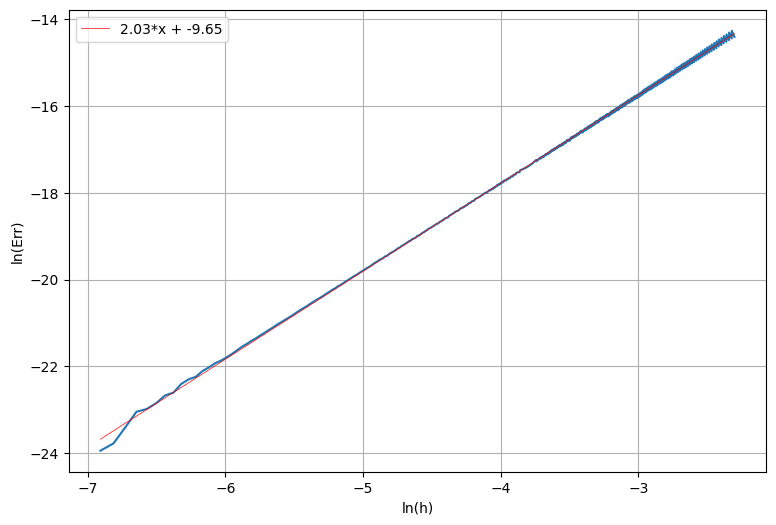

In [15]:
du2(0.001, 0.1, 0.0001, 1, 3, 1, trapezoidal)

#### Метод Рунге-Кутты 2 порядка

$$x_{n+1} = x_n + \tau\left(x_n + \frac{\tau}{2}x_n(1 - x_n)\right)\left(1 - x_n - \frac{\tau}{2}x_n(1 - x_n)\right)$$

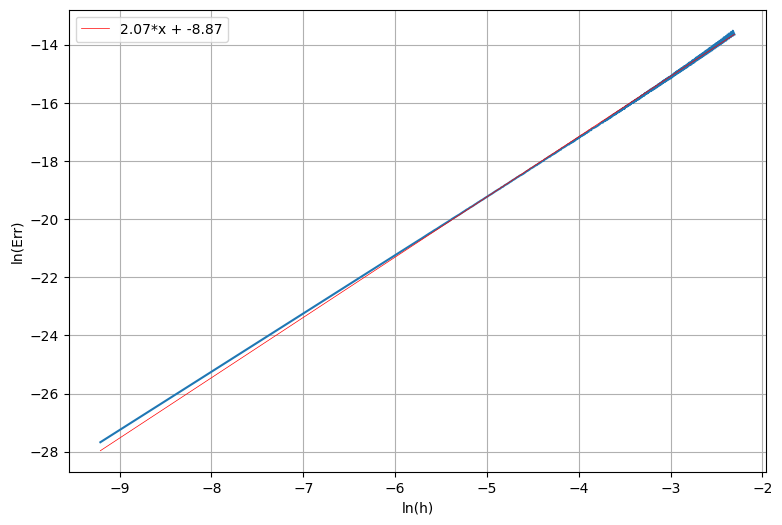

In [16]:
du2(0.0001, 0.1, 0.0001, 1, 3, 1, runge_kutta_2)

#### Метод Рунге-Кутты 4 порядка

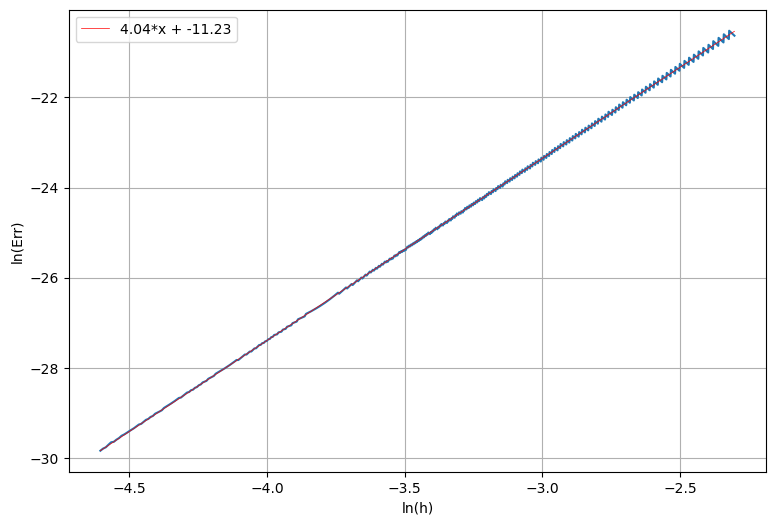

In [17]:
du2(0.01, 0.1, 0.0001, 1, 3, 1, runge_kutta_4)

## Решение системы ДУ

В качастве системы возьмем
$$\begin{pmatrix}
x(t)' \\
y(t)' \\
\end{pmatrix} = 
\begin{pmatrix}
-2x - 4y \\
2x + 2y \\
\end{pmatrix}$$
на отрезке $[a, b]$.
Решение
$$\begin{pmatrix}
x(t) \\
y(t) \\
\end{pmatrix} =
\begin{pmatrix}
c_1 (cos(2t) - sin(2t)) - 2c_2 sin(2t) \\
c_1 sin(2t) + c_2 (cos(2t) + sin(2t)) \\
\end{pmatrix}$$

In [18]:
my_dx  = lambda x, t: np.array([-2 * x[0] - 4 * x[1],
                                2 * x[0] + 2 * x[1]])

my_x_c = lambda t, c: np.array([c[0] * (m.cos(2 * t) - m.sin(2 * t)) - 2 * c[1] * m.sin(2 * t),
                                c[0] * m.sin(2 * t) + c[1] * (m.cos(2 * t) + m.sin(2 * t))])

def sdu(begin_h, end_h, step_h, x0, t0, method):
    a = t0; b = a + 1

    c = np.array([x0[0] * (m.cos(2 * t0) + m.sin(2 * t0)) + 2 * x0[1] * m.sin(2 * t0),
                  x0[1] * (m.cos(2 * t0) - m.sin(2 * t0)) - x0[0] * m.sin(2 * t0)])

    my_x = lambda t: my_x_c(t, c)

    logerr = LogError(begin_h, end_h, step_h, my_x, my_dx)
    logerr.calc(a, b, x0, method, True, 2)
    logerr.plot()

#### Явная схема Эйлера

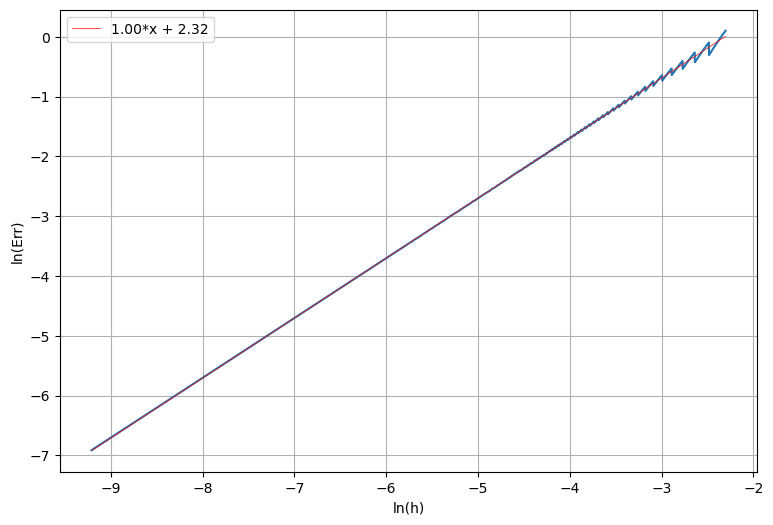

In [19]:
sdu(0.0001, 0.1, 0.0001, np.array([1, 2]), 0, explicit_euler)

#### Неявная схема Эйлера

In [20]:
def implicit_euler(gf, f):
    for i in range(1, gf.n):
        gf.y[i] = np.array([-2 * gf.y[i - 1][0] * gf.h + gf.y[i - 1][0] - 4 * gf.y[i - 1][1] * gf.h,
                            2 * gf.y[i - 1][0] * gf.h + 2 * gf.y[i - 1][1] * gf.h + gf.y[i - 1][1]]) / (4 * gf.h ** 2 + 1)

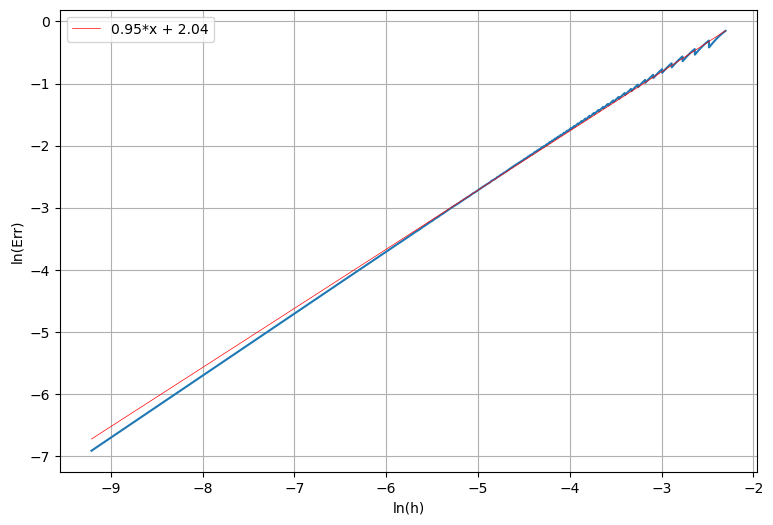

In [21]:
sdu(0.0001, 0.1, 0.0001, np.array([1, 2]), 0, implicit_euler)

#### Метод трапеций

In [22]:
def trapezoidal(gf, f):
    for i in range(1, gf.n):
        a = gf.y[i - 1][0] * (1 - gf.h) - 2 * gf.y[i - 1][1] * gf.h
        b = gf.y[i - 1][1] * (1 + gf.h) + gf.y[i - 1][0] * gf.h
        gf.y[i] = np.array([-a * gf.h + a - 2 * b * gf.h,
                            a * gf.h + b * gf.h + b]) / (gf.h ** 2 + 1)

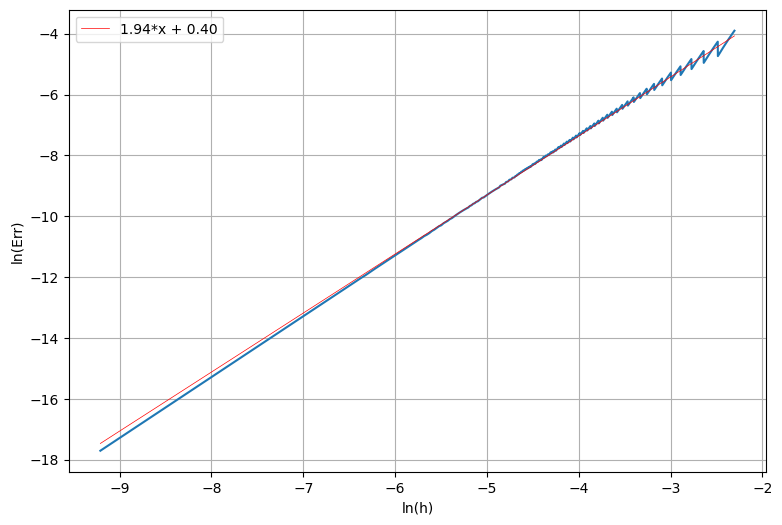

In [23]:
sdu(0.0001, 0.1, 0.0001, np.array([1, 2]), 0, trapezoidal)

#### Метод Рунге-Кутты 2 порядка

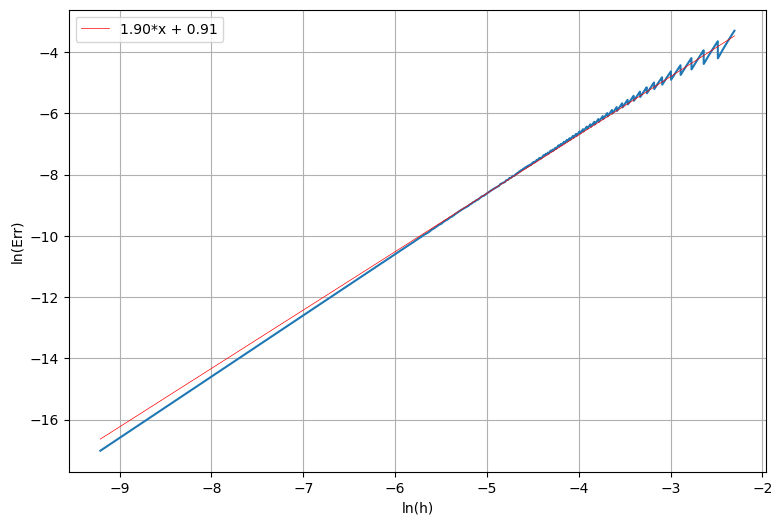

In [24]:
sdu(0.0001, 0.1, 0.0001, np.array([1, 2]), 0, runge_kutta_2)

#### Метод Рунге-Кутты 4 порядка

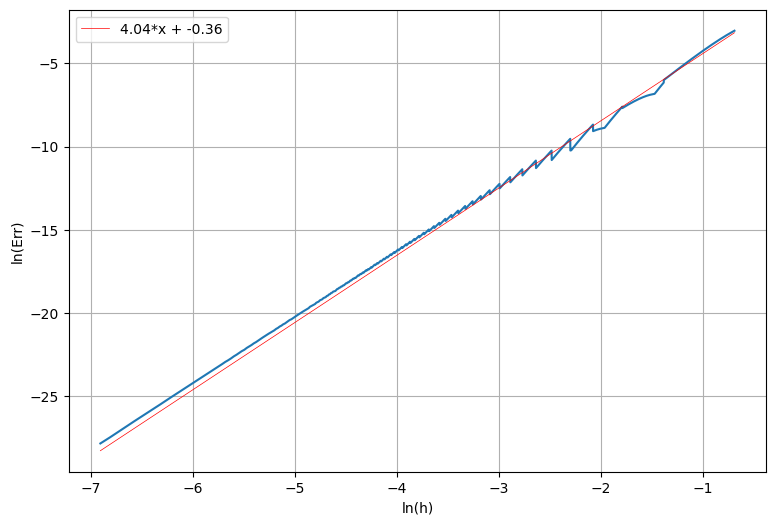

In [25]:
sdu(0.001, 0.5, 0.0001, np.array([1, 2]), 0, runge_kutta_4)

### Система Лотки-Вольтерры

$$\begin{pmatrix}
x(t)' \\
y(t)' \\
\end{pmatrix} = 
\begin{pmatrix}
a x - b xy \\
c xy - d y \\
\end{pmatrix}$$

In [4]:
my_dx_abcd = lambda x, t, a, b, c, d: np.array([a * x[0] - b * x[0] * x[1],
                                                c * x[0] * x[1] - d * x[1]])

def lotka_volterra(a, b, c, d, tau, tlen, x0, y0):
    my_dx = lambda x, t: my_dx_abcd(x, t, a, b, c, d)
    
    fig, axis = plt.subplots(2, 2, figsize=(10,5))
    axis[0, 0].set(title='Рунге-Кутты 2 порядка')
    axis[0, 1].set(title='Рунге-Кутты 4 порядка')
    axis[0, 0].grid(); axis[0, 1].grid()
    axis[1, 0].grid(); axis[1, 1].grid()

    solution_rk2 = GridFunction(0, tlen, tau, 2)
    solution_rk2.y[0] = np.array([x0, y0])
    runge_kutta_2(solution_rk2, my_dx)
    solution_rk2.plot('12', external=True, ext_plt=axis[0, 0])
    solution_rk2.plot('01', label='x', external=True, ext_plt=axis[1, 0])
    solution_rk2.plot('02', label='y', external=True, ext_plt=axis[1, 0])
    
    solution_rk4 = GridFunction(0, tlen, tau, 2)
    solution_rk4.y[0] = np.array([x0, y0])
    runge_kutta_4(solution_rk4, my_dx)
    solution_rk4.plot('12', external=True, ext_plt=axis[0, 1])
    solution_rk4.plot('01', label='x', external=True, ext_plt=axis[1, 1])
    solution_rk4.plot('02', label='y', external=True, ext_plt=axis[1, 1])

In [5]:
widg = interactive(lotka_volterra, a=(0.0,1.0), b=(0.0,1.0), c=(0.0,1.0), d=(0.0,1.0), tau=widgets.FloatSlider(min=0.001,max=1.0,step=0.001), tlen=(1,50), x0=(0.0,1.0), y0=(0.0,1.0))
widg

interactive(children=(FloatSlider(value=0.5, description='a', max=1.0), FloatSlider(value=0.5, description='b'…

### Система Лоренца

$$\begin{pmatrix}
x(t)' \\
y(t)' \\
z(t)' \\
\end{pmatrix} = 
\begin{pmatrix}
\sigma (y - x) \\
x(\rho - z) - y \\
xy - \beta z \\
\end{pmatrix}$$

In [2]:
my_dx_srb = lambda x, t, s, r, b: np.array([s * (x[1] - x[0]),
                                            x[0] * (r - x[2]) - x[1],
                                            x[0] * x[1] - b * x[2]])

def lorenz(s, r, b, tau, tlen, x0, y0, z0):
    my_dx = lambda x, t: my_dx_srb(x, t, s, r, b)
    
    fig, axis = plt.subplots(4, 2, figsize=(10,20))
    axis[0, 0].set(title='Рунге-Кутты 2 порядка')
    axis[0, 1].set(title='Рунге-Кутты 4 порядка')
    axis[0, 0].grid(); axis[0, 1].grid()
    axis[1, 0].grid(); axis[1, 1].grid()
    axis[2, 0].grid(); axis[2, 1].grid()
    axis[3, 0].grid(); axis[3, 1].grid()

    solution_rk2 = GridFunction(0, tlen, tau, 3)
    solution_rk2.y[0] = np.array([x0, y0, z0])
    runge_kutta_2(solution_rk2, my_dx)
    solution_rk2.plot('12', external=True, ext_plt=axis[0, 0])
    solution_rk2.plot('23', external=True, ext_plt=axis[1, 0])
    solution_rk2.plot('13', external=True, ext_plt=axis[2, 0])
    solution_rk2.plot('01', label='x', external=True, ext_plt=axis[3, 0])
    solution_rk2.plot('02', label='y', external=True, ext_plt=axis[3, 0])
    solution_rk2.plot('03', label='z', external=True, ext_plt=axis[3, 0])
    
    solution_rk4 = GridFunction(0, tlen, tau, 3)
    solution_rk4.y[0] = np.array([x0, y0, z0])
    runge_kutta_4(solution_rk4, my_dx)
    solution_rk4.plot('12', external=True, ext_plt=axis[0, 1])
    solution_rk4.plot('23', external=True, ext_plt=axis[1, 1])
    solution_rk4.plot('13', external=True, ext_plt=axis[2, 1])
    solution_rk4.plot('01', label='x', external=True, ext_plt=axis[3, 1])
    solution_rk4.plot('02', label='y', external=True, ext_plt=axis[3, 1])
    solution_rk4.plot('03', label='z', external=True, ext_plt=axis[3, 1])

In [3]:
widg = interactive(lorenz, s=widgets.FloatSlider(min=0.0,max=20.0,step=0.01,value=10.0), r=widgets.FloatSlider(min=0.0,max=30.0,step=0.1,value=28.0), b=widgets.FloatSlider(min=0.0,max=5.0,step=0.01,value=2.67), tau=widgets.FloatSlider(min=0.001,max=0.06,step=0.001), tlen=(1,50), x0=widgets.FloatSlider(min=-1.0,max=1.0,step=0.01, value=0.1), y0=widgets.FloatSlider(min=-1.0,max=1.0,step=0.01, value=0.1), z0=widgets.FloatSlider(min=-1.0,max=1.0,step=0.01, value=0.1))
widg

interactive(children=(FloatSlider(value=10.0, description='s', max=20.0, step=0.01), FloatSlider(value=28.0, d…

### Бифуркация

In [30]:
my_dx_srb = lambda x, t, s, r, b: np.array([s * (x[1] - x[0]),
                                            x[0] * (r - x[2]) - x[1],
                                            x[0] * x[1] - b * x[2]])

def bifurcation(tau, tlen, x0, y0, z0, rmax, a, b, c):
    s = 10
    b = 2.67

    bif_gf = GridFunction(0, rmax, rmax / 500.0, 0)

    def calc_bif(r):
        dx = lambda x, t: my_dx_srb(x, t, s, r, b)
        gf = GridFunction(0, tlen, tau, 3)
        gf.y[0] = np.array([x0, y0, z0])

        points = []
        d = 0.001
        for i in range(1, gf.n):
            k1 = dx(gf.y[i - 1], gf.x[i - 1])
            k2 = dx(gf.y[i - 1] + gf.h * k1 / 2, gf.x[i - 1] + gf.h / 2)
            k3 = dx(gf.y[i - 1] + gf.h * k2 / 2, gf.x[i - 1] + gf.h / 2)
            k4 = dx(gf.y[i - 1] + gf.h * k3, gf.x[i - 1] + gf.h)
            gf.y[i] = gf.y[i - 1] + gf.h / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

            d1 = a * gf.y[i][0] + b * gf.y[i][1] + c * gf.y[i][2]
            if d * d1 < 0:
                d = d1
                point = (gf.y[i][2] + gf.y[i - 1][2]) * 0.5
                if point < 400:
                    points.append(point)

        return np.asarray(points)

    bif_gf.calc(calc_bif, thread=True)
    bif_gf.plot()

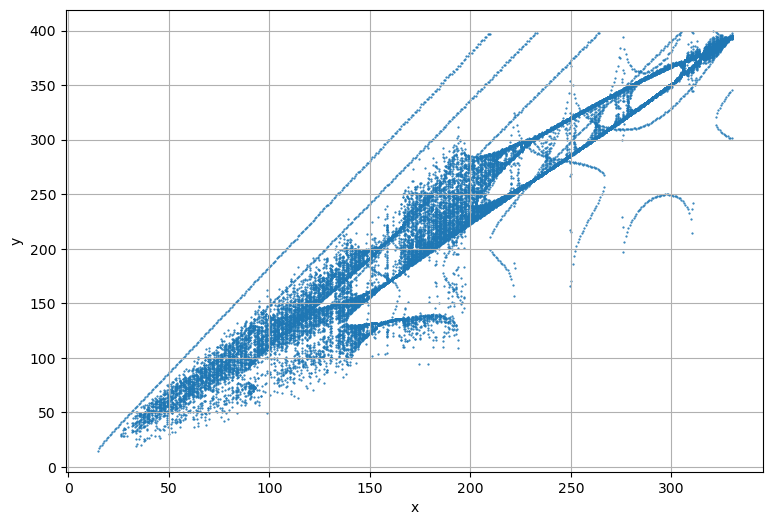

In [31]:
bifurcation(0.001, 20, 0.01, 0.01, 0.0, 330.0, 1.0, -1.0, 0.0)